In [19]:
import tensorflow as tf
import numpy as np
import os
from imutils import paths
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [20]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [21]:
DIRECTORY = r"D://AI ML DL//mask detection//Dataset mask detection//data//train"
CATEGORIES = ["with_mask", "without_mask"]

In [22]:

data=[]
labels=[]
for category in CATEGORIES:
    path = os.path.join(DIRECTORY,category)
    for img in os.listdir(path):
        imagepath = os.path.join(path, img)
        image = load_img(imagepath, target_size =(224,224))
        image = img_to_array(image)
        image = preprocess_input(image)

   
    #image = preprocess(image)

        data.append(image)
        labels.append(category)
data = np.array(data,dtype="float32")
labels = np.array(labels)

In [5]:
labels

array(['with_mask', 'with_mask', 'with_mask', ..., 'without_mask',
       'without_mask', 'without_mask'], dtype='<U12')

In [23]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
label = to_categorical(labels)

In [24]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.10, stratify=labels, random_state = 30)

In [25]:
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.3,height_shift_range=0.2,shear_range=0.2,horizontal_flip=True,fill_mode="nearest")

In [26]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224,224,3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name ="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="relu")(headModel)

model = Model(inputs = baseModel.input, outputs = headModel)
for layer in baseModel.layers:
    layer.trainable = False

In [27]:
opt = Adam(lr = INIT_LR, decay= INIT_LR/EPOCHS)
model.compile(loss= "binary_crossentropy", optimizer = opt, metrics=["accuracy"])

In [28]:
history =  model.fit(datagen.flow(trainX, trainY, batch_size = BS),steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
42/42 [==============================] - 53s 1s/step - loss: 3.7363 - accuracy: 0.4882 - val_loss: 0.3242 - val_accuracy: 0.6954
Epoch 2/20
42/42 [==============================] - 50s 1s/step - loss: 1.4030 - accuracy: 0.5701 - val_loss: 0.2164 - val_accuracy: 0.8344
Epoch 3/20
42/42 [==============================] - 52s 1s/step - loss: 0.9056 - accuracy: 0.7400 - val_loss: 0.1401 - val_accuracy: 0.8013
Epoch 4/20
42/42 [==============================] - 57s 1s/step - loss: 0.6125 - accuracy: 0.6967 - val_loss: 0.1177 - val_accuracy: 0.6821
Epoch 5/20
42/42 [==============================] - 60s 1s/step - loss: 0.5386 - accuracy: 0.6876 - val_loss: 0.1199 - val_accuracy: 0.7086
Epoch 6/20
42/42 [==============================] - 56s 1s/step - loss: 0.4490 - accuracy: 0.7051 - val_loss: 0.1142 - val_accuracy: 0.7682
Epoch 7/20
42/42 [==============================] - 54s 1s/step - loss: 0.4367 - accuracy: 0.7453 - val_loss: 0.1116 - val_accuracy: 0.7086
Epoch 8/20
42/42 [==

In [29]:
predidxs = model.predict(testX, batch_size =BS)
predidxs = np.argmax(predidxs, axis =1)
print(classification_report(testY.argmax(axis=1), predidxs, target_names = lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      0.59      0.74       151
without_mask       0.00      0.00      0.00         0

    accuracy                           0.59       151
   macro avg       0.50      0.29      0.37       151
weighted avg       1.00      0.59      0.74       151

C:\ProgramData\Anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\ai\lib\site-p

In [30]:
fname = "trained_model_new.hdf5"
model.save(fname,overwrite=True)

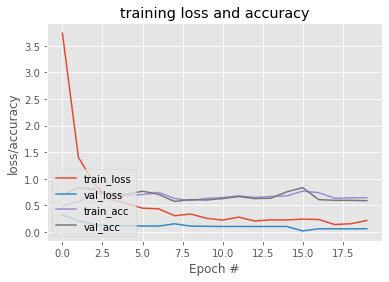

In [31]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N),history.history["loss"],label = "train_loss")
plt.plot(np.arange(0,N),history.history["val_loss"],label = "val_loss")
plt.plot(np.arange(0,N),history.history["accuracy"],label = "train_acc")
plt.plot(np.arange(0,N),history.history["val_accuracy"],label = "val_acc")
plt.title("training loss and accuracy")
plt.xlabel("Epoch #")
plt.ylabel("loss/accuracy")
plt.legend(loc = "lower left")
plt.savefig("plot.png")